In [1]:
# 1. Data Preparation - Download and extract the Food-10 dataset, organize it into train/ and test/ folders suitable for PyTorch’s ImageFolder.

import zipfile

zip_path = "archive.zip"   

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

print("✅ Extraction completed!")

✅ Extraction completed!


In [2]:
import os

print(os.listdir("food-10"))

['images', 'test.txt', 'train.txt']


In [3]:
root = "food-10"
images_dir = os.path.join(root, "images")

train_list_path = os.path.join(root, "train.txt")
test_list_path  = os.path.join(root, "test.txt")

def read_split(path):
    with open(path, "r") as f:
        return [line.strip() for line in f]

train_list = read_split(train_list_path)
test_list = read_split(test_list_path)

print("Train images:", len(train_list))
print("Test images:", len(test_list))

Train images: 7500
Test images: 2500


In [4]:
train_root = "train"
test_root = "test"

os.makedirs(train_root, exist_ok=True)
os.makedirs(test_root, exist_ok=True)

print("Folders created!")

Folders created!


In [5]:
import shutil

def copy_images(file_list, dest_root):
    for item in file_list:
        class_name, img_name = item.split('/')

        class_folder = os.path.join(dest_root, class_name)
        os.makedirs(class_folder, exist_ok=True)
        
        src = os.path.join(images_dir, class_name, img_name + ".jpg")
        dst = os.path.join(class_folder, img_name + ".jpg")

        if os.path.exists(src) and not os.path.exists(dst):
            shutil.copy2(src, dst)
    
    print(f"Finished copying → {dest_root}")

copy_images(train_list, train_root)
copy_images(test_list, test_root)

Finished copying → train
Finished copying → test


In [6]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = ImageFolder("train", transform=transform)
test_data = ImageFolder("test", transform=transform)

print("Number of training images:", len(train_data))
print("Number of test images:", len(test_data))
print("Number of classes:", len(train_data.classes))

Number of training images: 7500
Number of test images: 2500
Number of classes: 10


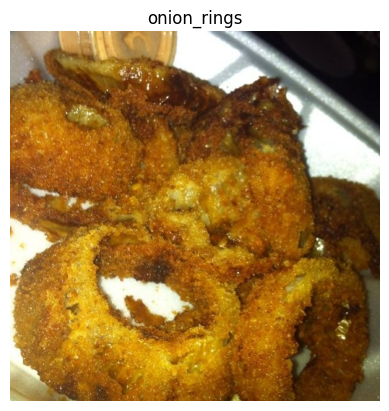

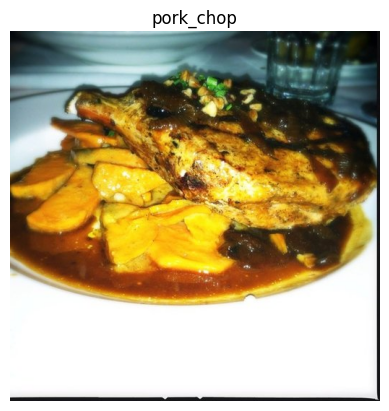

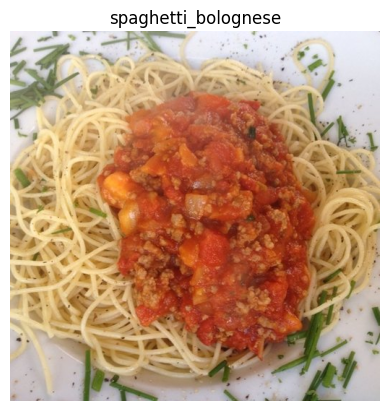

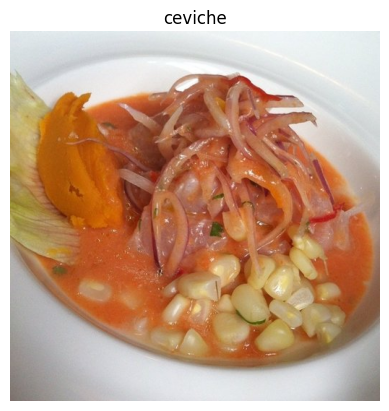

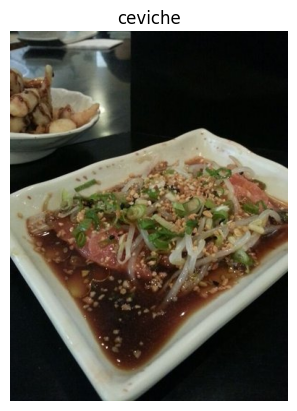

In [7]:
# 2. Exploratory Data Analysis (EDA) - Visualize sample images, check class distribution, and inspect image resolutions.

import matplotlib.pyplot as plt
import numpy as np
import random

def show_image(dataset, index):
    img, label = dataset[index]
    img = img.numpy().transpose(1, 2, 0) 
    plt.imshow(img)
    plt.title(dataset.classes[label])
    plt.axis("off")
    plt.show()

num_images = 7500

random_indices = random.sample(range(num_images), 5)

for i in random_indices:
    show_image(train_data, i)

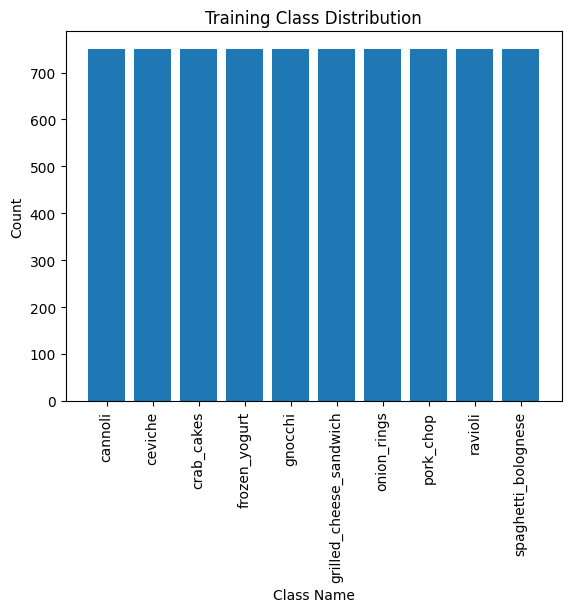

In [14]:
from collections import Counter

labels = [label for _, label in train_data]
count = Counter(labels)

class_names = train_data.classes  

plt.bar(class_names, count.values())
plt.title("Training Class Distribution")
plt.xlabel("Class Name")
plt.ylabel("Count")

plt.xticks(rotation=90)

plt.show()

In [15]:
import pandas as pd

df = pd.DataFrame({
    "class": train_data.classes,
    "count": [count[i] for i in range(len(train_data.classes))]
})
df

,class,count
0,cannoli,750
1,ceviche,750
2,crab_cakes,750
3,frozen_yogurt,750
4,gnocchi,750
5,grilled_cheese_sandwich,750
6,onion_rings,750
7,pork_chop,750
8,ravioli,750
9,spaghetti_bolognese,750


In [16]:
from PIL import Image

widths = []
heights = []

for class_name in train_data.classes:
    folder = f"train/{class_name}"
    
    for img_name in os.listdir(folder)[:2]: 
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        widths.append(img.width)
        heights.append(img.height)

print("Average width:", np.mean(widths))
print("Average height:", np.mean(heights))
print("Min width:", np.min(widths), "Max width:", np.max(widths))
print("Min height:", np.min(heights), "Max height:", np.max(heights))

Average width: 499.1
Average height: 455.9
Min width: 382 Max width: 512
Min height: 288 Max height: 512


In [17]:
# 3. Data augmentation - Apply random flips, rotations, color jitter, and normalization for better generalization.

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),          
    transforms.RandomHorizontalFlip(),      
    transforms.RandomRotation(10),         
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),                                      
    transforms.ToTensor(),
    
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [18]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),       
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [19]:
from torchvision.datasets import ImageFolder

train_data = ImageFolder("train", transform=train_transform)
test_data = ImageFolder("test", transform=test_transform)

In [20]:
from torch.utils.data import DataLoader, random_split

val_size = int(0.1 * len(train_data)) 
train_size = len(train_data) - val_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_data, batch_size=8, shuffle=False, num_workers=0)

In [21]:
# 4. Model selection (Transfer Learning) - Use pretrained CNNs such as ResNet-50 or EfficientNet-B0 from torchvision.

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

num_classes = 10
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

Using: cpu


In [22]:
# 5. Training pipeline - Implement loss function, optimizer (AdamW), and learning-rate scheduling; train with validation monitoring.

from tqdm import tqdm

def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs=10, model_name="model"):

    best_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 30)

        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc="Training batches"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        avg_val_loss = val_loss / len(val_loader)

        scheduler.step()

        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {avg_val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_{model_name}.pth")
            print(f"🔥 Saved Best Model: best_{model_name}.pth")

    print(f"\nTraining complete! Best validation accuracy for {model_name}: {best_acc:.4f}")
    return model

In [28]:
# 6. Evaluation metrics - Compute macro F1-score, confusion matrix, and per-class performance.

from sklearn.metrics import f1_score, confusion_matrix, classification_report

def evaluate_metrics(model, data_loader, class_names):
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            preds.extend(predicted.cpu().numpy())
            trues.extend(labels.cpu().numpy())

    macro_f1 = f1_score(trues, preds, average='macro')
    print("\n📌 Macro F1 Score:", macro_f1)

    print("\n📌 Classification Report (Per-Class Metrics):")
    print(classification_report(trues, preds, target_names=class_names))

    cm = confusion_matrix(trues, preds)
    print("\n📌 Confusion Matrix:")
    print(cm)

    return macro_f1, cm

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def get_preds(model):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            preds.extend(predicted.cpu().numpy())
            trues.extend(labels.cpu().numpy())
    return preds, trues

In [60]:
from torchvision import models

resnet_50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

for param in resnet_50.parameters():
    param.requires_grad = False

for name, param in resnet_50.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
        
resnet_50.fc = nn.Linear(resnet_50.fc.in_features, num_classes)
resnet_50 = resnet_50.to(device)

optimizer_resnet = torch.optim.AdamW(filter(lambda p: p.requires_grad, resnet_50.parameters()), lr=3e-5)
scheduler_resnet = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_resnet, T_max=2 )

print("\nTraining ResNet-50...")
resnet_50 = train_model(resnet_50, train_loader, val_loader, optimizer_resnet, scheduler_resnet, epochs=10, model_name="resnet_50")

class_names = train_data.classes
resnet_50_macro_f1, resnet_50_cm = evaluate_metrics(resnet_50, test_loader, class_names)

print("\nFinal Macro F1:", resnet_50_macro_f1)

res_preds, res_trues = get_preds(resnet_50)
res_acc  = accuracy_score(res_trues, res_preds)
res_prec = precision_score(res_trues, res_preds, average="macro", zero_division=0)
res_rec  = recall_score(res_trues, res_preds, average="macro", zero_division=0)
res_f1   = resnet_50_macro_f1


Training ResNet-50...

Epoch 1/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [43:32<00:00,  3.10s/it]


Train Loss: 1.6031 | Train Acc: 0.5621
Val   Loss: 1.0760 | Val   Acc: 0.7667
🔥 Saved Best Model: best_resnet_50.pth

Epoch 2/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [34:02<00:00,  2.42s/it]


Train Loss: 1.1290 | Train Acc: 0.7341
Val   Loss: 1.0045 | Val   Acc: 0.8000
🔥 Saved Best Model: best_resnet_50.pth

Epoch 3/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [33:26<00:00,  2.38s/it]


Train Loss: 1.0855 | Train Acc: 0.7538
Val   Loss: 1.0044 | Val   Acc: 0.8000

Epoch 4/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [39:41<00:00,  2.82s/it]


Train Loss: 1.0504 | Train Acc: 0.7735
Val   Loss: 0.9605 | Val   Acc: 0.8067
🔥 Saved Best Model: best_resnet_50.pth

Epoch 5/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [35:10<00:00,  2.50s/it]


Train Loss: 1.0016 | Train Acc: 0.7999
Val   Loss: 0.9426 | Val   Acc: 0.8200
🔥 Saved Best Model: best_resnet_50.pth

Epoch 6/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [33:03<00:00,  2.35s/it]


Train Loss: 0.9380 | Train Acc: 0.8224
Val   Loss: 0.9115 | Val   Acc: 0.8347
🔥 Saved Best Model: best_resnet_50.pth

Epoch 7/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [38:01<00:00,  2.70s/it]


Train Loss: 0.9121 | Train Acc: 0.8373
Val   Loss: 0.8921 | Val   Acc: 0.8493
🔥 Saved Best Model: best_resnet_50.pth

Epoch 8/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [37:46<00:00,  2.69s/it]


Train Loss: 0.9216 | Train Acc: 0.8308
Val   Loss: 0.8799 | Val   Acc: 0.8587
🔥 Saved Best Model: best_resnet_50.pth

Epoch 9/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [45:50<00:00,  3.26s/it]


Train Loss: 0.8928 | Train Acc: 0.8418
Val   Loss: 0.8785 | Val   Acc: 0.8427

Epoch 10/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [38:11<00:00,  2.71s/it]


Train Loss: 0.8497 | Train Acc: 0.8676
Val   Loss: 0.8698 | Val   Acc: 0.8560

Training complete! Best validation accuracy for resnet_50: 0.8587

📌 Macro F1 Score: 0.9077054302953418

📌 Classification Report (Per-Class Metrics):
                         precision    recall  f1-score   support

                cannoli       0.95      0.98      0.96       250
                ceviche       0.88      0.88      0.88       250
             crab_cakes       0.90      0.86      0.88       250
          frozen_yogurt       0.98      0.99      0.98       250
                gnocchi       0.78      0.88      0.83       250
grilled_cheese_sandwich       0.95      0.94      0.95       250
            onion_rings       0.99      0.97      0.98       250
              pork_chop       0.89      0.90      0.90       250
                ravioli       0.84      0.71      0.77       250
    spaghetti_bolognese       0.94      0.96      0.95       250

               accuracy                           0.91

In [66]:
efficientnet_b0 = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

for param in efficientnet_b0.parameters():
    param.requires_grad = False

for name, param in efficientnet_b0.named_parameters():
    if "features.6" in name or "features.7" in name or "classifier" in name:
        param.requires_grad = True
        
efficientnet_b0.classifier[1] = nn.Linear(efficientnet_b0.classifier[1].in_features, num_classes)
efficientnet_b0 = efficientnet_b0.to(device)

optimizer_effnet = torch.optim.AdamW(filter(lambda p: p.requires_grad, efficientnet_b0.parameters()), lr=3e-5)
scheduler_effnet = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_effnet, T_max=2)

print("\nTraining EfficientNet-B0...")
efficientnet_b0 = train_model(efficientnet_b0, train_loader, val_loader, optimizer_effnet, scheduler_effnet, epochs=10, model_name="efficientnet_b0")

class_names = train_data.classes
efficientnet_b0_macro_f1, efficientnet_b0_cm = evaluate_metrics(efficientnet_b0, test_loader, class_names)

print("\nFinal Macro F1:", efficientnet_b0_macro_f1)

eff_preds, eff_trues = get_preds(efficientnet_b0)
eff_acc  = accuracy_score(eff_trues, eff_preds)
eff_prec = precision_score(eff_trues, eff_preds, average="macro", zero_division=0)
eff_rec  = recall_score(eff_trues, eff_preds, average="macro", zero_division=0)
eff_f1   = efficientnet_b0_macro_f1


Training EfficientNet-B0...

Epoch 1/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [21:55<00:00,  1.56s/it]


Train Loss: 1.9513 | Train Acc: 0.4169
Val   Loss: 1.4249 | Val   Acc: 0.7053
🔥 Saved Best Model: best_efficientnet_b0.pth

Epoch 2/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [21:38<00:00,  1.54s/it]


Train Loss: 1.4617 | Train Acc: 0.6321
Val   Loss: 1.1945 | Val   Acc: 0.7440
🔥 Saved Best Model: best_efficientnet_b0.pth

Epoch 3/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [20:40<00:00,  1.47s/it]


Train Loss: 1.3589 | Train Acc: 0.6658
Val   Loss: 1.1877 | Val   Acc: 0.7640
🔥 Saved Best Model: best_efficientnet_b0.pth

Epoch 4/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [19:55<00:00,  1.42s/it]


Train Loss: 1.3017 | Train Acc: 0.6790
Val   Loss: 1.0905 | Val   Acc: 0.7733
🔥 Saved Best Model: best_efficientnet_b0.pth

Epoch 5/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [19:56<00:00,  1.42s/it]


Train Loss: 1.1956 | Train Acc: 0.7096
Val   Loss: 1.0062 | Val   Acc: 0.8027
🔥 Saved Best Model: best_efficientnet_b0.pth

Epoch 6/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [21:14<00:00,  1.51s/it]


Train Loss: 1.1261 | Train Acc: 0.7399
Val   Loss: 0.9773 | Val   Acc: 0.8147
🔥 Saved Best Model: best_efficientnet_b0.pth

Epoch 7/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [20:52<00:00,  1.48s/it]


Train Loss: 1.1140 | Train Acc: 0.7439
Val   Loss: 1.0021 | Val   Acc: 0.8120

Epoch 8/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [20:23<00:00,  1.45s/it]


Train Loss: 1.0959 | Train Acc: 0.7519
Val   Loss: 0.9673 | Val   Acc: 0.8173
🔥 Saved Best Model: best_efficientnet_b0.pth

Epoch 9/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [20:58<00:00,  1.49s/it]


Train Loss: 1.0769 | Train Acc: 0.7606
Val   Loss: 0.9494 | Val   Acc: 0.8360
🔥 Saved Best Model: best_efficientnet_b0.pth

Epoch 10/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [20:20<00:00,  1.45s/it]


Train Loss: 1.0223 | Train Acc: 0.7859
Val   Loss: 0.9470 | Val   Acc: 0.8267

Training complete! Best validation accuracy for efficientnet_b0: 0.8360

📌 Macro F1 Score: 0.8791686836035755

📌 Classification Report (Per-Class Metrics):
                         precision    recall  f1-score   support

                cannoli       0.91      0.96      0.93       250
                ceviche       0.90      0.76      0.83       250
             crab_cakes       0.73      0.90      0.81       250
          frozen_yogurt       1.00      0.98      0.99       250
                gnocchi       0.79      0.82      0.80       250
grilled_cheese_sandwich       0.93      0.92      0.93       250
            onion_rings       0.99      0.96      0.98       250
              pork_chop       0.86      0.85      0.86       250
                ravioli       0.79      0.69      0.74       250
    spaghetti_bolognese       0.91      0.97      0.94       250

               accuracy                         

In [67]:
mobilenet_v3 = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)

for param in mobilenet_v3.parameters():
    param.requires_grad = False

for name, param in mobilenet_v3.named_parameters():
    if "features.14" in name or "features.15" in name or "features.16" in name or "classifier" in name:
        param.requires_grad = True
        
mobilenet_v3.classifier[3] = nn.Linear(mobilenet_v3.classifier[3].in_features, num_classes)
mobilenet_v3 = mobilenet_v3.to(device)

optimizer_mobilenet = torch.optim.AdamW(filter(lambda p: p.requires_grad, mobilenet_v3.parameters()), lr=3e-5)
scheduler_mobilenet = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_mobilenet, T_max=2)

print("\nTraining MobileNetV3-Large...")
mobilenet_v3 = train_model(mobilenet_v3, train_loader, val_loader, optimizer_mobilenet, scheduler_mobilenet, epochs=10, model_name="mobilenet_v3")

class_names = train_data.classes
mobilenet_v3_macro_f1, mobilenet_v3_cm = evaluate_metrics(mobilenet_v3, test_loader, class_names)

print("\nFinal Macro F1:", mobilenet_v3_macro_f1)

mob_preds, mob_trues = get_preds(mobilenet_v3)
mob_acc  = accuracy_score(mob_trues, mob_preds)
mob_prec = precision_score(mob_trues, mob_preds, average="macro", zero_division=0)
mob_rec  = recall_score(mob_trues, mob_preds, average="macro", zero_division=0)
mob_f1   = mobilenet_v3_macro_f1


Training MobileNetV3-Large...

Epoch 1/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [12:55<00:00,  1.09it/s]


Train Loss: 1.6750 | Train Acc: 0.5190
Val   Loss: 1.1628 | Val   Acc: 0.7440
🔥 Saved Best Model: best_mobilenet_v3.pth

Epoch 2/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [12:48<00:00,  1.10it/s]


Train Loss: 1.2625 | Train Acc: 0.6809
Val   Loss: 1.0752 | Val   Acc: 0.7707
🔥 Saved Best Model: best_mobilenet_v3.pth

Epoch 3/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [13:56<00:00,  1.01it/s]


Train Loss: 1.1950 | Train Acc: 0.7123
Val   Loss: 1.0906 | Val   Acc: 0.7787
🔥 Saved Best Model: best_mobilenet_v3.pth

Epoch 4/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [13:34<00:00,  1.04it/s]


Train Loss: 1.1818 | Train Acc: 0.7185
Val   Loss: 1.0551 | Val   Acc: 0.7853
🔥 Saved Best Model: best_mobilenet_v3.pth

Epoch 5/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [12:58<00:00,  1.08it/s]


Train Loss: 1.1308 | Train Acc: 0.7364
Val   Loss: 1.0217 | Val   Acc: 0.7827

Epoch 6/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [12:06<00:00,  1.16it/s]


Train Loss: 1.0814 | Train Acc: 0.7659
Val   Loss: 0.9964 | Val   Acc: 0.8000
🔥 Saved Best Model: best_mobilenet_v3.pth

Epoch 7/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [12:10<00:00,  1.16it/s]


Train Loss: 1.0719 | Train Acc: 0.7711
Val   Loss: 0.9958 | Val   Acc: 0.8120
🔥 Saved Best Model: best_mobilenet_v3.pth

Epoch 8/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [13:21<00:00,  1.05it/s]


Train Loss: 1.0638 | Train Acc: 0.7735
Val   Loss: 0.9950 | Val   Acc: 0.8067

Epoch 9/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [12:45<00:00,  1.10it/s]


Train Loss: 1.0547 | Train Acc: 0.7770
Val   Loss: 0.9923 | Val   Acc: 0.8067

Epoch 10/10
------------------------------


Training batches: 100%|██████████████████████████████████████████████████████████████| 844/844 [13:14<00:00,  1.06it/s]


Train Loss: 0.9999 | Train Acc: 0.8044
Val   Loss: 0.9690 | Val   Acc: 0.8133
🔥 Saved Best Model: best_mobilenet_v3.pth

Training complete! Best validation accuracy for mobilenet_v3: 0.8133

📌 Macro F1 Score: 0.8653744523881844

📌 Classification Report (Per-Class Metrics):
                         precision    recall  f1-score   support

                cannoli       0.90      0.94      0.92       250
                ceviche       0.85      0.77      0.81       250
             crab_cakes       0.73      0.83      0.78       250
          frozen_yogurt       0.96      0.99      0.97       250
                gnocchi       0.76      0.81      0.78       250
grilled_cheese_sandwich       0.93      0.89      0.91       250
            onion_rings       1.00      0.93      0.96       250
              pork_chop       0.91      0.80      0.85       250
                ravioli       0.79      0.74      0.77       250
    spaghetti_bolognese       0.85      0.96      0.90       250

         

In [68]:
df_compare = pd.DataFrame([
    ["ResNet-50", res_acc, res_prec, res_rec, res_f1],
    ["EfficientNet-B0", eff_acc, eff_prec, eff_rec, eff_f1],
    ["MobileNet-V3", mob_acc, mob_prec, mob_rec, mob_f1],
], columns=["Model", "Accuracy", "Precision", "Recall", "Macro F1"])

print(df_compare)

best_row = df_compare.loc[df_compare["Macro F1"].idxmax()]
best_model_name = best_row["Model"]
print("Best model:", best_model_name)

if best_model_name == "ResNet-50":
    best_model = resnet_50
elif best_model_name == "EfficientNet-B0":
    best_model = efficientnet_b0
else:
    best_model = mobilenet_v3

torch.save(best_model.state_dict(), "best_model_auto_selected.pth")
print("Saved: best_model_auto_selected.pth")

             Model  Accuracy  Precision  Recall  Macro F1
0        ResNet-50    0.9084   0.909027  0.9084  0.907705
1  EfficientNet-B0    0.8796   0.882768  0.8796  0.879169
2     MobileNet-V3    0.8652   0.868593  0.8652  0.865374
Best model: ResNet-50
Saved: best_model_auto_selected.pth


In [69]:
# 7. Model interpretation (optional) - Visualize Grad-CAM heatmaps to understand which image regions drive predictions.

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer

        self.activations = None

        def forward_hook(module, input, output):
            self.activations = output.detach()

        self.target_layer.register_forward_hook(forward_hook)

    def generate(self, input_tensor, class_idx=None):
        input_tensor.requires_grad = True
        
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        output[0, class_idx].backward()

        gradients = input_tensor.grad.detach()  

        activations = self.activations

        pooled_gradients = torch.mean(gradients[0], dim=(1, 2))

        cam = torch.zeros(activations.shape[2:], dtype=torch.float32)

        for i, w in enumerate(pooled_gradients):
            cam += w * activations[0, i]

        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= cam.max()

        return cam.cpu().numpy()

In [70]:
import cv2

def show_gradcam(img_tensor, cam):
    img = img_tensor.squeeze().permute(1,2,0).cpu().numpy()
    img = img - img.min()
    img = img / img.max()

    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap((cam*255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = heatmap.astype(np.float32) / 255

    superimposed = heatmap * 0.4 + img
    superimposed /= superimposed.max()

    plt.imshow(superimposed)
    plt.axis('off')
    plt.show()

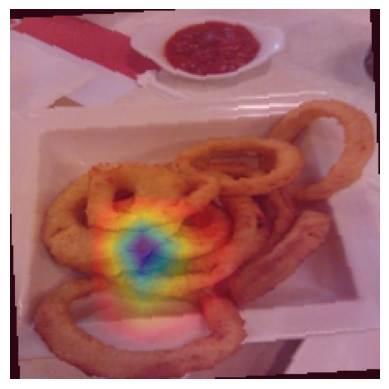

In [71]:
images, labels = next(iter(val_loader))
images = images.to(device)

target_layer = resnet_50.layer4[-1] 

gradcam = GradCAM(resnet_50, target_layer)

cam = gradcam.generate(images[0].unsqueeze(0))
show_gradcam(images[0].unsqueeze(0), cam)

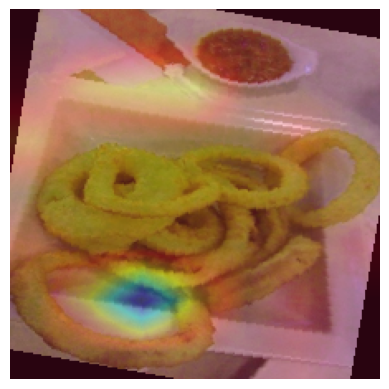

In [72]:
images, labels = next(iter(val_loader))
images = images.to(device)

target_layer = efficientnet_b0.features[-1]  

gradcam = GradCAM(efficientnet_b0, target_layer)

cam = gradcam.generate(images[0].unsqueeze(0))
show_gradcam(images[0].unsqueeze(0), cam)

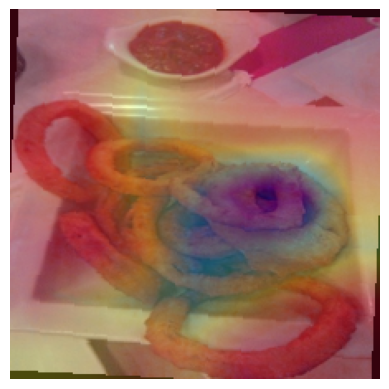

In [73]:
images, labels = next(iter(val_loader))
images = images.to(device)

target_layer = mobilenet_v3.features[-1]

gradcam = GradCAM(mobilenet_v3, target_layer)

cam = gradcam.generate(images[0].unsqueeze(0))
show_gradcam(images[0].unsqueeze(0), cam)